In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns;sns.set()
%matplotlib inline

In [2]:
#load data
car_price = pd.read_csv('car_price.csv')

# EDA
Explore the data to gain insights

In [3]:
pd.options.display.max_columns = None  #列数
pd.options.display.max_rows = None     #行数

In [4]:
car_price['price_cut'] = pd.qcut(car_price['price'].sort_values(),10)

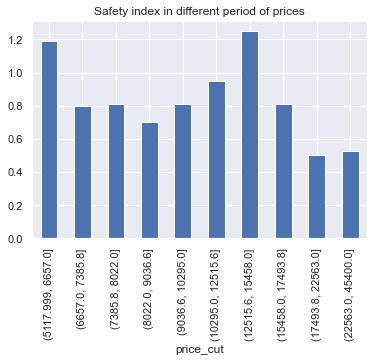

In [5]:
car_price.groupby('price_cut')['symboling'].mean().plot(kind='bar',
                                                        title='Safety index in different period of prices');

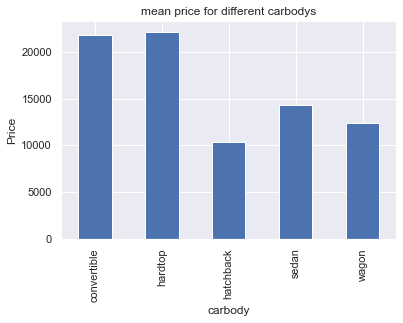

In [6]:
car_price.groupby('carbody')['price'].mean().plot(kind='bar',
                                                    title='mean price for different carbodys',
                                                 ylabel='Price');

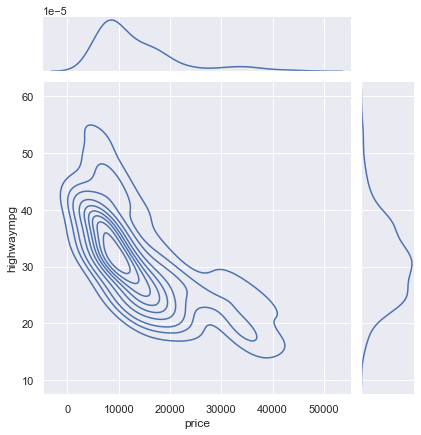

In [7]:
#jointplot between highwaympg and price
sns.jointplot(x='price',y='highwaympg',data=car_price,kind='kde');

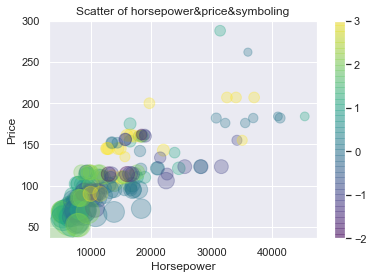

In [8]:
plt.scatter(car_price['price'],car_price['horsepower'],c=car_price['symboling'],
            cmap='viridis',alpha=0.3,s=0.4*car_price['citympg']**2)
plt.xlabel('Horsepower')
plt.ylabel('Price')
plt.title('Scatter of horsepower&price&symboling')
plt.colorbar();

In [9]:
car_price['volume']=car_price['carlength']*car_price['carwidth']*car_price['carheight']/10000
car_price['speed']=(car_price['citympg']+car_price['highwaympg'])/2

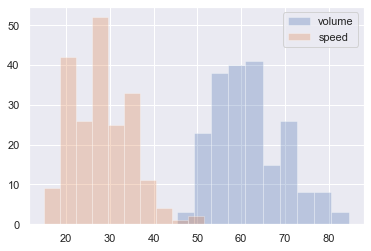

In [10]:
car_price['volume'].hist(alpha=0.3,label='volume');
car_price['speed'].hist(alpha=0.3,label='speed');
plt.legend(loc='best');

remove attributes with less importance and fit the model
* 'car_ID','CarName','volume'

In [11]:
df = car_price.drop(['car_ID','CarName','volume'],axis=1)

# Prepare the data to better expose the underlying data patterns to Machine Learning algorithms

In [12]:
df['boreratio']=df['boreratio'].round(1)
df['stroke']=df['stroke'].round(1)

* Strong correlation: horsepower & price
* Normal correlation: horsepower & boreratio

In [13]:
int_df=df[['symboling','horsepower','peakrpm']]
float_df=df[['boreratio','stroke','price','speed','carlength', 'carwidth', 'carheight', 'curbweight']]
str_df=df[['fueltype', 'doornumber', 'carbody', 'drivewheel',
       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem','price_cut']]

In [14]:
int_attribs=list(int_df)
float_attribs=list(float_df)
str_attribis=list(str_df)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#归一化
from sklearn.preprocessing import StandardScaler
#OneHotLabelEncoder
from sklearn.preprocessing import OneHotEncoder

pipeline = ColumnTransformer([
    ('int',StandardScaler(),int_attribs+float_attribs),
    ('cat',OneHotEncoder(),str_attribis)
])

In [16]:
car_prepared = pipeline.fit_transform(df)
car_prepared.shape

(205, 57)

# Fit in models

## GMM

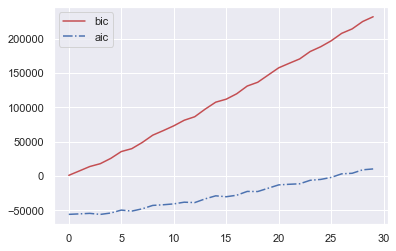

In [17]:
from sklearn.mixture import GaussianMixture
bic=[]
aic=[]
range_n_cluster = range(10,40)
for num_clusters in range_n_cluster:
    gm = GaussianMixture(n_components=num_clusters)
    gm.fit(car_prepared)
    
    bic.append(gm.bic(car_prepared))
    aic.append(gm.aic(car_prepared))
plt.plot(bic,'r-',label='bic')
plt.plot(aic,'b-.',label='aic')
plt.legend(loc='best')

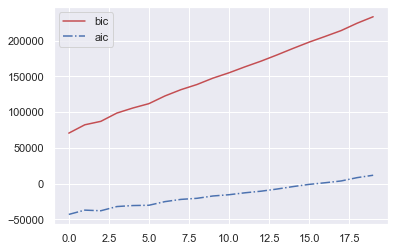

In [18]:
bic=[]
aic=[]
range_n_cluster = range(20,40)
for num_clusters in range_n_cluster:
    gm = GaussianMixture(n_components=num_clusters)
    gm.fit(car_prepared)
    
    bic.append(gm.bic(car_prepared))
    aic.append(gm.aic(car_prepared))
plt.plot(bic,'r-',label='bic')
plt.plot(aic,'b-.',label='aic')
plt.legend(loc='best')

In [19]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=36)
gm.fit(car_prepared)
gmm_pre = gm.predict(car_prepared)
gmm_result = car_price.copy()
gmm_result['cluster']=gmm_pre

# Output the result

In [20]:
sp_result=gmm_result.copy()

In [21]:
result=sp_result[sp_result['CarName'].str.contains('volkswagen')][['CarName','carbody','cluster']]
result=result.append(sp_result[sp_result['CarName'].str.contains('vw')][['CarName','carbody','cluster']])
result=result.append(sp_result[sp_result['CarName'].str.contains('vokswage')][['CarName','carbody','cluster']])

result.reset_index(inplace=True)
result.drop('index',axis=1,inplace=True)

clusters = result['cluster'].sort_values().unique()

for i in clusters:
    whole = list(sp_result[sp_result['cluster']==i]['CarName'].values)
    part = list(result[result['cluster']==i]['CarName'].values)
    print(part,' has competitors:',[item for item in whole if item not in set(part)],'\n\n')

['volkswagen 1131 deluxe sedan', 'volkswagen type 3', 'volkswagen 411 (sw)', 'volkswagen dasher']  has competitors: ['audi 100 ls'] 


['volkswagen model 111', 'volkswagen super beetle', 'vokswagen rabbit']  has competitors: ['nissan gt-r', 'toyota corolla'] 


['volkswagen dasher']  has competitors: ['honda prelude', 'honda accord', 'honda civic', 'honda civic (auto)', 'mitsubishi outlander', 'mitsubishi mirage g4'] 


['vw dasher', 'vw rabbit']  has competitors: ['dodge d200', 'dodge coronet custom', 'mitsubishi mirage g4', 'mitsubishi g4'] 


['volkswagen rabbit custom']  has competitors: ['mazda glc deluxe', 'mazda rx-7 gs', 'toyota corona', 'toyota corolla', 'toyota celica gt', 'toyota corona', 'toyota corolla', 'toyota mark ii'] 


['volkswagen rabbit']  has competitors: ['audi 100ls', 'audi fox', 'audi 5000s (diesel)'] 




# KMeans

In [22]:
from sklearn.cluster import KMeans
k=20
kmeans = KMeans(n_clusters=k,max_iter=50)
y_pred=kmeans.fit_predict(car_prepared)

kmeans_result=car_price.copy()
kmeans_result['cluster']=y_pred

### Determine the optimal number of cluster

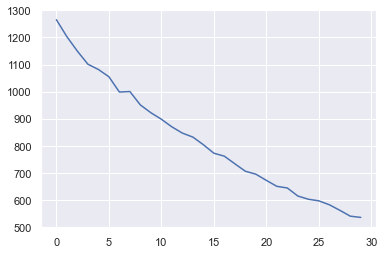

In [23]:
ssd=[]
range_n_cluster = range(10,40)
for num_clusters in range_n_cluster:
    kmeans = KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(car_prepared)
    
    ssd.append(kmeans.inertia_)
plt.plot(ssd)

In [24]:
#Silhouette coefficient
from sklearn.metrics import silhouette_score
range_n_clusters=range(20,40)

for num_clusters in range_n_clusters:
    kmeans=KMeans(n_clusters=num_clusters)
    kmeans.fit(car_prepared)
    
    cluster_labels=kmeans.labels_
    
    silhouette_avg = silhouette_score(car_prepared,cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=20, the silhouette score is 0.19699402823313886
For n_clusters=21, the silhouette score is 0.22339277420811204
For n_clusters=22, the silhouette score is 0.20575338341359853
For n_clusters=23, the silhouette score is 0.20149286037428707
For n_clusters=24, the silhouette score is 0.20934695860224384
For n_clusters=25, the silhouette score is 0.19001663802795507
For n_clusters=26, the silhouette score is 0.21372904768330406
For n_clusters=27, the silhouette score is 0.22577567668540183
For n_clusters=28, the silhouette score is 0.22585797491047377
For n_clusters=29, the silhouette score is 0.21710833392691148
For n_clusters=30, the silhouette score is 0.24415014315924177
For n_clusters=31, the silhouette score is 0.24813885901131374
For n_clusters=32, the silhouette score is 0.2406374736935414
For n_clusters=33, the silhouette score is 0.23577518806313355
For n_clusters=34, the silhouette score is 0.2541320835556445
For n_clusters=35, the silhouette score is 0.250048842061

In [25]:
k=36
kmeans_2 = KMeans(n_clusters=k,max_iter=50)
y_pred_2=kmeans_2.fit_predict(car_prepared)

In [26]:
kmeans_result = car_price.copy()
kmeans_result['cluster']=y_pred_2

In [27]:
#output
sp_result =kmeans_result.copy()
result=sp_result[sp_result['CarName'].str.contains('volkswagen')][['CarName','carbody','cluster']]
result=result.append(sp_result[sp_result['CarName'].str.contains('vw')][['CarName','carbody','cluster']])
result=result.append(sp_result[sp_result['CarName'].str.contains('vokswage')][['CarName','carbody','cluster']])

result.reset_index(inplace=True)
result.drop('index',axis=1,inplace=True)

clusters = result['cluster'].sort_values().unique()

for i in clusters:
    whole = list(sp_result[sp_result['cluster']==i]['CarName'].values)
    part = list(result[result['cluster']==i]['CarName'].values)
    print(part,' has competitors:',[item for item in whole if item not in set(part)],'\n\n')

['volkswagen rabbit custom']  has competitors: ['mazda glc deluxe', 'mazda rx-7 gs', 'toyota corona', 'toyota celica gt'] 


['volkswagen 1131 deluxe sedan', 'volkswagen type 3', 'volkswagen 411 (sw)', 'volkswagen dasher', 'volkswagen rabbit', 'volkswagen dasher', 'vw dasher']  has competitors: ['audi 100 ls', 'audi fox', 'honda civic', 'mitsubishi outlander'] 


['vw rabbit']  has competitors: ['dodge d200', 'dodge coronet custom', 'honda civic cvcc', 'honda accord cvcc', 'honda civic cvcc', 'mitsubishi g4', 'plymouth cricket'] 


['volkswagen model 111', 'volkswagen super beetle', 'vokswagen rabbit']  has competitors: ['nissan gt-r', 'toyota corolla'] 


